In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd

from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
class EmbeddingDotProduct(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim):
        super(EmbeddingDotProduct, self).__init__()

        self.user_biases = nn.Embedding(num_users, 1)
        self.item_biases = nn.Embedding(num_items, 1)

        self.user_embeddings = nn.Embedding(num_users, embedding_dim)
        self.item_embeddings = nn.Embedding(num_items, embedding_dim)

    def forward(self, user_indices, item_indices):
        user_embedding = self.user_embeddings(user_indices)
        item_embedding = self.item_embeddings(item_indices)

        user_bias = self.user_biases(user_indices)
        item_bias = self.item_biases(item_indices)

        if item_indices.dim() == 2:
            user_embedding = user_embedding.unsqueeze(1)

        i_b = item_bias.sum(-1)
        ui = (user_embedding * item_embedding).sum(-1)

        if len(i_b.shape) == 2:
          u_b = user_bias
        else:
          u_b = user_bias.sum(-1)


        return u_b + i_b + ui

In [4]:
def bpr_loss(positive_scores, negative_scores):
    return -torch.mean(torch.log(torch.sigmoid(positive_scores.unsqueeze(1) - negative_scores)))
  
def bpr_logit_loss(positive_scores, negative_scores, true_values_logits):
    bpr_part = -torch.mean(torch.log(torch.sigmoid(positive_scores.unsqueeze(1) - negative_scores)))
    logit_part_positive = torch.mean((positive_scores - true_values_logits) ** 2)

    return bpr_part + 0.1*logit_part_positive

In [5]:
def generate_negative_samples(num_items, positive_items, num_neg_samples): 
    #there can be intersections with positives but odds are low.
    negative_samples = np.random.choice(num_items, (positive_items.shape[0], num_neg_samples), replace=False)
    return negative_samples

In [6]:
# params of algorithm

THRESHOLD = 60

In [7]:
scores_train = np.load("./drive/MyDrive/ВШМ/DL/scores_train.npy")
interactions_train = np.load("./drive/MyDrive/ВШМ/DL/interactions_train.npy")

In [8]:
scores_test = np.load("./drive/MyDrive/ВШМ/DL/scores_test.npy")
interactions_test = np.load("./drive/MyDrive/ВШМ/DL/interactions_test.npy")

In [9]:
shuffled_ixs = np.random.shuffle(list(range(0, interactions_train.shape[0])))

interactions_train = interactions_train[shuffled_ixs, :].squeeze(0)
scores_train = scores_train[shuffled_ixs, :].squeeze(0)

positive_interactions_train = interactions_train[scores_train >= THRESHOLD]
positive_interactions_test = interactions_test[scores_test >= THRESHOLD]

In [10]:
scores_train_probas = scores_train[scores_train >= THRESHOLD] / 100.0
scores_train_logits = np.log(scores_train_probas / ((1 - scores_train_probas) + 1e-6))

In [11]:
num_users = int(interactions_train[:, 0].max()) + 1
num_items = int(interactions_train[:, 1].max()) + 1
embedding_dim = 64

In [12]:
model = EmbeddingDotProduct(num_users, num_items, embedding_dim)

optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

EmbeddingDotProduct(
  (user_biases): Embedding(249012, 1)
  (item_biases): Embedding(296111, 1)
  (user_embeddings): Embedding(249012, 64)
  (item_embeddings): Embedding(296111, 64)
)

In [42]:
num_epochs = 10
batch_size = 32000
num_negative_samples = 5

total_epochs = len(positive_interactions_train) // batch_size
loss_per_epoch = []

positive_users_tensor = torch.LongTensor(positive_interactions_train[:, 0]).to(device)
positive_items_tensor = torch.LongTensor(positive_interactions_train[:, 1]).to(device)
scores_logits_tensor = torch.FloatTensor(scores_train_logits).to(device)

for epoch in range(num_epochs):
    epoch_losses = []

    for ix, batch_start in tqdm(enumerate(range(0, len(positive_interactions_train), batch_size)), total=total_epochs):
        batch_data = positive_interactions_train[batch_start:batch_start + batch_size]
        #batch_target = scores_train_logits[batch_start:batch_start + batch_size]

        #batch_positive_users = torch.LongTensor(batch_data[:, 0]).to(device)
        #batch_positive_items = torch.LongTensor(batch_data[:, 1]).to(device)
        #batch_positive_logits = torch.FloatTensor(batch_target).to(device)

        batch_positive_users = positive_users_tensor[batch_start:batch_start + batch_size]
        batch_positive_items = positive_items_tensor[batch_start:batch_start + batch_size]
        batch_positive_logits = scores_logits_tensor[batch_start:batch_start + batch_size]

        
        # Sample negative items
        batch_negative_items_np = generate_negative_samples(num_items, batch_data[:, 1], num_negative_samples)
        batch_negative_items = torch.LongTensor(batch_negative_items_np).to(device)
        
        # Calculate scores
        positive_scores = model(batch_positive_users, batch_positive_items)
        negative_scores = model(batch_positive_users, batch_negative_items)
        
        # Compute loss
        loss = bpr_logit_loss(positive_scores, negative_scores, batch_positive_logits)
        epoch_losses.append(loss.detach().cpu())
        # Backpropagate and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #add evaluation code here
    loss_per_epoch.append(np.mean(epoch_losses))
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {loss_per_epoch[-1]}")
    epoch_losses = []

<ipython-input-42-fabb88fae11c>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ix, batch_start in tqdm(enumerate(range(0, len(positive_interactions_train), batch_size)), total=total_epochs):


  0%|          | 0/943 [00:00<?, ?it/s]

Epoch 1/10 - Loss: 0.30899110436439514


  0%|          | 0/943 [00:00<?, ?it/s]

Epoch 2/10 - Loss: 0.3077981173992157


  0%|          | 0/943 [00:00<?, ?it/s]

Epoch 3/10 - Loss: 0.3064541518688202


  0%|          | 0/943 [00:00<?, ?it/s]

Epoch 4/10 - Loss: 0.30526095628738403


  0%|          | 0/943 [00:00<?, ?it/s]

Epoch 5/10 - Loss: 0.30398029088974


  0%|          | 0/943 [00:00<?, ?it/s]

Epoch 6/10 - Loss: 0.3027592897415161


  0%|          | 0/943 [00:00<?, ?it/s]

Epoch 7/10 - Loss: 0.30152609944343567


  0%|          | 0/943 [00:00<?, ?it/s]

Epoch 8/10 - Loss: 0.30031418800354004


  0%|          | 0/943 [00:00<?, ?it/s]

Epoch 9/10 - Loss: 0.299126535654068


  0%|          | 0/943 [00:00<?, ?it/s]

Epoch 10/10 - Loss: 0.29800742864608765


In [21]:
positive_interactions_train.shape, scores_train_logits.shape

((30185738, 2), (30185738,))

<Axes: >

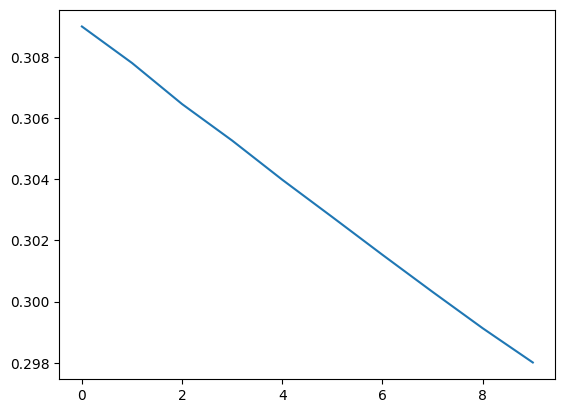

In [43]:
pd.Series(loss_per_epoch).plot()

In [44]:
test_users = torch.LongTensor(interactions_test[:, 0]).to(device)
test_items = torch.LongTensor(interactions_test[:, 1]).to(device)


preds = model(test_users, test_items)
scores_pred = torch.sigmoid(preds).detach().cpu().numpy()

In [45]:
accuracy_score(scores_pred >= 0.6, scores_test / 100. >= 0.6)

0.7480231684655834

In [46]:
roc_auc_score(scores_test / 100. >= 0.6, scores_pred)

0.8019792873407678